# Package Imports

In [1]:
import pandas as pd
from pathlib import Path
import time
import tqdm
from datetime import datetime
import os
from sklearn.model_selection import KFold, train_test_split
import sys
import torch.nn.functional as F
import pytorch_lightning as plit
from scipy.sparse import csr_matrix
import pandas as pd
import random
import math
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, normalize, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_recall_curve, confusion_matrix, roc_curve, matthews_corrcoef, auc
from sklearn.metrics import auc as skauc
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from fancyimpute import IterativeImputer as MICE
from sklearn.compose import ColumnTransformer
import numpy as np
from multiprocessing import Pool
import multiprocessing
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from xgboost import XGBClassifier, XGBRegressor
import torch.nn as nn
import shap
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from torch.utils.data import DataLoader, TensorDataset
import torch
import argparse
import dateutil
from collections import defaultdict
from scipy.stats import gaussian_kde
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PolynomialFeatures
from scipy.interpolate import interp1d
import joblib

# Torch device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# K-fold validation
n_splits = 5  
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Autoencoder for Patient Codes

In [2]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder layers
        self.encoder_fc1 = nn.Linear(input_dim, 256)
        self.encoder_fc2_mean = nn.Linear(256, latent_dim)  # Output mean
        self.encoder_fc2_logvar = nn.Linear(256, latent_dim)  # Output log variance
        
        # Decoder layers
        self.decoder_fc1 = nn.Linear(latent_dim, 256)
        self.decoder_fc2 = nn.Linear(256, input_dim)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = F.relu(self.encoder_fc1(x))
        return self.encoder_fc2_mean(x), self.encoder_fc2_logvar(x)

    def decode(self, z):
        x = F.relu(self.decoder_fc1(z))
        return torch.sigmoid(self.decoder_fc2(x))

    def forward(self, x):
        # Encoding
        z_mean, z_log_var = self.encode(x)

        # Sampling
        z = self.reparameterize(z_mean, z_log_var)

        # Decoding
        reconstructed = self.decode(z)
        
        return reconstructed, z_mean, z_log_var
    
    def infer(self, x):
        # Encoding
        z_mean, _ = self.encode(x)
        z_mean = z_mean.detach().numpy()[0]
        return z_mean
        
class AutoEncoder:
    def __init__(self, ICD = 'dataset/ADMISSIONS.csv',
                 conversion = 'dataset/D_ICD_DIAGNOSES.csv',
                 max_length = 6,
                 latent_dim = 1,
                 threshold = 3):
        
        # Loads data
        ICD = pd.read_csv(ICD)
        patient_diagnoses = list(ICD['DIAGNOSIS'])
        full_diagnoses = []
        frequencies = defaultdict(int)
        for diag in patient_diagnoses:
            try:
                diag = diag.split(';')
                full_diagnoses.append(diag)
            except:
                full_diagnoses.append([])
        for diag in full_diagnoses:
            for d in diag:
                frequencies[d] += 1
        # Filter full_diagnoses list
        filtered_diagnoses = [
            [d for d in diag if frequencies[d] >= threshold]
            for diag in full_diagnoses
        ]
        
        # Creates basic label encoder
        self.code_converter = {}
        counter = 0
        for key, value in frequencies.items():
            if value >= threshold:
                self.code_converter[key] = counter
                counter += 1
                
        # Tokenizes full_diagnoses list
        tokenized_diagnoses = [
            [d for d in diag if frequencies[d] >= threshold]
            for diag in filtered_diagnoses
        ]
        
        subject_codes = defaultdict(list)

        for num, row in tqdm.tqdm(ICD.iterrows(), total = len(ICD), desc = 'Creating code features'):
            subject_id = row['SUBJECT_ID']
            diagnoses_list = tokenized_diagnoses[num]
            for diagnoses in diagnoses_list:
                try:
                    subject_codes[subject_id].append(self.code_converter[diagnoses])
                except:
                    self.code_converter[diagnoses] = len(self.code_converter)
                    subject_codes[subject_id].append(self.code_converter[diagnoses])
                
        subject_codes = dict(subject_codes)
        self.subjects = list(subject_codes.keys())

        # Obtains tensors
        self.input_tensors = []
        self.max_length = max_length
        for num, (subject_id, codes) in tqdm.tqdm(enumerate(subject_codes.items()), total = len(subject_codes), desc = 'Padding samples'):
            while len(codes) < max_length:
                codes.append(0)
            if len(codes) > max_length:
                codes = random.sample(codes, max_length)
            self.input_tensors.append(torch.FloatTensor(codes))

        # Scales data
        self.scaler = StandardScaler()
        self.input_tensors = torch.FloatTensor(self.scaler.fit_transform(self.input_tensors))
        
        # Makes VAE
        self.autoencoder = VAE(input_dim = self.max_length, latent_dim = latent_dim)

    def train_VAE(self, batch_size = 32,
                 num_epochs = 10):
        
        # Define the DataLoader
        batch_size = 16
        data_loader = DataLoader(self.input_tensors, batch_size=batch_size, shuffle=True)

        # Define the loss function and optimizer
        def loss_function(reconstructed_x, x, mu, log_var):
            # Reconstruction loss (MSE)
            recon_loss = F.mse_loss(reconstructed_x, x) / x.size(0)  # Divide by batch size for stability
            
            # KL divergence
            kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / x.size(0)
        
            return recon_loss + kld_loss

        optimizer = torch.optim.Adam(self.autoencoder.parameters(), lr=0.0001)

        # Training loop
        self.autoencoder.train()
        for epoch in range(num_epochs):
            total_loss = 0.0
            for i, data in enumerate(tqdm.tqdm(data_loader, total=len(data_loader), desc=f'Epoch {epoch}')):
                optimizer.zero_grad()
                outputs, mu, log_var = self.autoencoder(data)
                loss = loss_function(outputs, data, mu, log_var)
            
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(data_loader):.4f}')

        # Obtains encoded features
        encoded_features = []
        for feature in tqdm.tqdm(self.input_tensors, total = len(self.input_tensors), desc = 'Encoding...'):
            feature = self.autoencoder.infer(feature)
            encoded_features.append(feature)
            
        return encoded_features

    def extract_features(self, data, scale = True):
        data = np.array(data)
        self.autoencoder.eval()
        
        if len(data) < self.max_length:    
            while len(data) < self.max_length:
                data = np.append(data, 0)
                
        elif len(data) > self.max_length:
            data = data[self.max_length]

        data = self.scaler.transform([data])
        
        outputs = self.autoencoder.infer(torch.FloatTensor(data)).detach().numpy()[0]
        return outputs


# Feature Analysis + Filtration

In [3]:
def analyze_features(features_scaled, feature_names, y, top_n_features=10, return_top_features=False):
    """
    Analyze features using SHAP values, Linear Regression, and PCA,
    select the top features from each method without duplicates, and visualize the results.

    :param features_scaled: Scaled feature numpy array
    :param feature_names: List of feature names
    :param y: True labels
    :param top_n_features: Number of top features to retain from each method
    """
    # Trains XGBoost classifier for SHAP
    xgb_model = XGBClassifier()
    xgb_model.fit(features_scaled, y)
    
    # Linear Regression for feature importance
    lr_model = LinearRegression()
    lr_model.fit(features_scaled, y)

    # SHAP values
    explainer_shap = shap.Explainer(xgb_model)
    shap_values = explainer_shap(features_scaled)
    sampled_features = shap.sample(features_scaled, 1000)
    explainer_tree = shap.TreeExplainer(xgb_model)
    shap_values_tree = explainer_tree.shap_values(sampled_features)

    # Feature importance from SHAP
    feature_importance_shap = np.abs(shap_values.values).mean(axis=0)
    top_features_shap = np.argsort(feature_importance_shap)[-top_n_features:]

    # Principal Component Analysis
    pca = PCA(n_components=len(feature_names))
    pca.fit(features_scaled)
    feature_importance_pca = pca.explained_variance_ratio_
    top_features_pca = np.argsort(feature_importance_pca)[-top_n_features:]

    # Visualization
    
    # Visualize SHAP values using summary plot
    shap.summary_plot(shap_values_tree, sampled_features, feature_names=feature_names)

    # Print feature importance based on SHAP
    feature_importance_shap_tree = np.abs(shap_values_tree).mean(axis=0)
    feature_importance_shap_tree = pd.Series(feature_importance_shap_tree, index=feature_names).sort_values(ascending=False)
    print("\nFeature importance based on SHAP TreeExplainer:")
    print(feature_importance_shap_tree.head(top_n_features))
    print("\n" + "-"*50 + "\n")

    # Linear Regression
    plt.figure(figsize=(6, 10))
    indices_lr = np.argsort(np.abs(lr_model.coef_))[::-1][:top_n_features]
    plt.title("Top Linear Regression Coefficients")
    plt.barh(range(top_n_features), np.abs(lr_model.coef_)[indices_lr], color='b', align='center')
    plt.yticks(range(top_n_features), [feature_names[i] for i in indices_lr])
    plt.xscale('log')
    plt.gca().invert_yaxis()  # Invert y-axis to have largest values at the top
    plt.show()
    
    # PCA
    plt.figure(figsize=(6, 10))
    plt.title("Top PCA Explained Variance Ratio")
    plt.barh(range(top_n_features), feature_importance_pca[top_features_pca], color='b', align='center')
    plt.yticks(range(top_n_features), [feature_names[i] for i in top_features_pca])
    plt.show()
    
    # Combine and remove duplicates
    combined_feature_indices = np.unique(np.concatenate((top_features_shap, indices_lr, top_features_pca)))
    combined_feature_names = [feature_names[i] for i in combined_feature_indices]

    print(f"Number of selected features: {len(combined_feature_names)}")
    print("Selected features:", combined_feature_names)

    if return_top_features:
        return combined_feature_names


def process_data_chunk_wrapper(chunk, id_conversion):
    """
    Calls process_data_chunk with the given chunk and id_conversion.
    """
    return process_data_chunk(chunk, id_conversion)
    
# Filters features based on their presence in the final patient dataset
def filter_features_on_presence(feature_df, feature_threshold =0.5, patient_threshold = 0.5):
    presence = feature_df.notna().mean()
    filtered_columns = presence[presence > feature_threshold].index
    feature_df = feature_df[filtered_columns]
    
    # Calculate the minimum number of non-NaN/None values required per row based on the proportion
    min_non_nan_count = int(np.ceil(patient_threshold * feature_df.shape[1]))
    
    # Filter rows based on the calculated minimum count of non-NaN/None values
    filtered_df = feature_df.dropna(axis=0, thresh=min_non_nan_count)
    
    return filtered_df
    
def filter_chart_data_optimized(chart_data, admissions_data, max_hours=48, chunks=4):
    # Ensure datetime format
    chart_data['CHARTTIME'] = pd.to_datetime(chart_data['CHARTTIME'], errors='coerce')
    admissions_data['ADMITTIME'] = pd.to_datetime(admissions_data['ADMITTIME'], errors='coerce')

    # Determine chunk size
    chunk_size = len(chart_data) // chunks
    filtered_data_list = []

    for i in range(chunks):
        # Calculate start and end index for each chunk
        start_idx = i * chunk_size
        end_idx = (i + 1) * chunk_size if i < chunks - 1 else len(chart_data)
        chart_data_chunk = chart_data.iloc[start_idx:end_idx]

        # Merge with admissions_data
        merged_data = chart_data_chunk.merge(admissions_data[['SUBJECT_ID', 'ADMITTIME']],
                                             on='SUBJECT_ID', how='inner')
        # Calculate time difference in hours
        merged_data['time_diff'] = (merged_data['CHARTTIME'] - merged_data['ADMITTIME']).dt.total_seconds() / 3600

        # Filter based on time_diff
        filtered_chunk = merged_data.query('0 <= time_diff <= @max_hours').drop(columns=['ADMITTIME', 'time_diff'])
        filtered_data_list.append(filtered_chunk)

    # Concatenate all filtered chunks
    filtered_data = pd.concat(filtered_data_list, ignore_index=True)
    
    return filtered_data
    
def extract_features_from_chart_data(chart_data, id_conversion, num_processes=16, min_non_nan_proportion=0.01):
    """
    Extract features from chart data using multiprocessing.
    """
    # Split data into chunks
    chunks = np.array_split(chart_data, num_processes)
    
    # Prepare arguments for each chunk processing
    args = [(chunk, id_conversion) for chunk in chunks]
    
    # Process each chunk in parallel
    with Pool(num_processes) as pool:
        results = pool.starmap(process_data_chunk_wrapper, args)
    
    # Combine results from all chunks
    combined = pd.concat(results, axis=0).reset_index(drop=True).groupby('SUBJECT_ID').first()
    
    # Determine the threshold number of non-NaN/non-None values required per column
    threshold_count = int(min_non_nan_proportion * len(combined))
    
    # Drop columns where the number of non-NaN/non-None values is less than the threshold
    filtered_combined = combined.dropna(axis=1, thresh=threshold_count, inplace=False)
    
    return filtered_combined 
    
def process_data_chunk(chunk, id_conversion, value_pick='last'):
    """
    Extract features from a chunk of data, preserving SUBJECT_ID.
    Args:
        - chunk (DataFrame): A chunk of the filtered chart data, preserving SUBJECT_ID.
        - id_conversion (dict): A dictionary for converting item IDs to feature names.
        - value_pick (str): Determines whether to pick the 'first' or 'last' non-empty value for each feature.
    Returns:
        - DataFrame with extracted features for the chunk, including SUBJECT_ID.
    """

    # Ensure SUBJECT_ID is considered during processing
    chunk['FEATURE_NAME'] = chunk['ITEMID'].map(id_conversion).fillna('Unknown')

    # Define aggregation function based on value_pick parameter
    if value_pick == 'first':
        value_func = lambda x: x.dropna().iloc[0] if not x.dropna().empty else None
    elif value_pick == 'last':
        value_func = lambda x: x.dropna().iloc[-1] if not x.dropna().empty else None
    elif value_pick == 'mean':
        value_func = lambda x: x.dropna().iloc[:] if not x.dropna().empty() else None
    else:
        raise ValueError("value_pick must be 'first' or 'last' or 'mean'")

    agg_funcs = {'VALUE': value_func}
    features = chunk.groupby(['SUBJECT_ID', 'FEATURE_NAME']).agg(agg_funcs).unstack()

    # Flatten Multi-Index columns
    features.columns = [f'{i}_{j}' for i, j in features.columns]
    return features.reset_index()
    
def filter_patients_within_timeframe(data, max_hours):

    max_seconds = max_hours * 3600
    # Mark patients to keep based on the condition
    keep_patients = []
    for i, row in data.iterrows():
        if pd.notnull(row['DEATHTIME']):
            time_diff = (row['DEATHTIME'] - row['ADMITTIME']).total_seconds()
        else:
            time_diff = (row['DISCHTIME'] - row['ADMITTIME']).total_seconds()
        
        if time_diff > max_seconds:
            keep_patients.append(row['SUBJECT_ID'])
    
    return keep_patients

# Filters out labels within a given timeframe
def process_data_with_timeframe_filtering(admit_times, discharge_times, death_times, filter_within_timeframe, max_hours, subject_ids):
    death_labels = []
    hospital_stay = []
    filtered_ids = []
    
    for admit, dis, death, subject_id in tqdm.tqdm(zip(admit_times, discharge_times, death_times, subject_ids), total=len(admit_times), desc='Processing mortality'):
        within_timeframe = False
        death_time = (death - admit).total_seconds() if pd.notnull(death) else None
        discharge_time = (dis - admit).total_seconds() if pd.notnull(dis) else None
        
        if death_time and death_time <= max_hours * 3600:
            within_timeframe = True
        elif discharge_time and discharge_time <= max_hours * 3600:
            within_timeframe = True
        
        if filter_within_timeframe and within_timeframe:
            continue  # Skip this patient
        
        # Add the patient's data
        hospital_stay.append(death_time if death_time else discharge_time)
        death_labels.append(1 if death_time else 0)
        filtered_ids.append(subject_id)
    
    return death_labels, hospital_stay, filtered_ids

# Processes prescriptions
def process_prescriptions(prescriptions_df, 
                          mortality_labels,
                          admissions_df,
                          selected_type = 'dose',
                          max_hours = 6,
                          top_features = 100):

    # Define conversion factors for dosage units
    conversion_factors = {
        'mg': 1,
        'mcg': 0.001,
        'g': 1000,
        'pill': 50,
        'tab': 50,
        'gm': 1000,
        'mEq': 74.5,
        'mL': 1,
        'UNIT': 100,
        'mcg/hr': 0.001,
        'mg/hr': 1,
    }

    # Converts start date to datetime format
    prescriptions_df['STARTDATE'] = pd.to_datetime(prescriptions_df['STARTDATE'])

    # Merge prescriptions_df with admissions_df on SUBJECT_ID
    prescriptions_df = pd.merge(prescriptions_df, admissions_df[['SUBJECT_ID', 'ADMITTIME']], on='SUBJECT_ID', how='left')

    # Filter prescriptions for STARTDATE before ADMITTIME plus max_hours
    prescriptions_df = prescriptions_df[prescriptions_df['STARTDATE'] < (prescriptions_df['ADMITTIME'] + pd.Timedelta(hours=max_hours))]

    # Convert DOSE_UNIT_RX to conversion factors and multiply by DOSE_VAL_RX to get dose in mg
    prescriptions_df['DOSE_VAL_RX'] = pd.to_numeric(prescriptions_df['DOSE_VAL_RX'], errors='coerce').fillna(0)
    prescriptions_df['dose_mg'] = prescriptions_df['DOSE_VAL_RX'] * prescriptions_df['DOSE_UNIT_RX'].map(conversion_factors).fillna(1)
    
    grouped_dosages = prescriptions_df.groupby(['SUBJECT_ID', 'DRUG'])['dose_mg'].sum().unstack(fill_value=0)
    grouped_counts = prescriptions_df.groupby(['SUBJECT_ID', 'DRUG']).size().unstack(fill_value=0)

    if selected_type == 'count':
        # Group by unique patient ID and DRUG to count occurrences and sum dosages   
        final_df = grouped_counts 
    elif selected_type == 'dose':
        final_df = grouped_dosages

    print(f'Final prescriptions shape: {final_df.shape}')
    
    # Reset the index to convert 'SUBJECT_ID' back to a regular column
    final_df.reset_index(inplace=True)

    # selects only numerical data
    numeric_features = final_df.select_dtypes(include=['float64', 'int64']).columns
    final_df = final_df[numeric_features]
    
    def format_column_names(df):
        # Step 1: Store original column names and format them
        original_cols = df.columns.tolist()
        cleaned_cols = ["".join(c for c in col if c.isalnum() or c == '_').strip('_') for col in original_cols]
    
        # Check for duplicates in the cleaned column names
        seen = set()
        duplicates_indices = []
        for i, col in enumerate(cleaned_cols):
            if col in seen:
                duplicates_indices.append(i)  # Mark duplicate for removal
            else:
                seen.add(col)
        
        # Create a mapping of cleaned column names to original column names, excluding duplicates
        cleaned_to_original = {cleaned_cols[i]: original_cols[i] for i in range(len(cleaned_cols)) if i not in duplicates_indices}
    
        # Collect columns to be added to the new dataframe
        columns_to_add = {cleaned: df[original] for cleaned, original in cleaned_to_original.items()}
    
        # Create a new dataframe with non-duplicate, cleaned column names, preserving the data
        # using pd.concat for efficient memory usage and avoiding fragmentation
        new_df = pd.concat(columns_to_add, axis=1)
    
        return new_df
    
    final_df = format_column_names(final_df)
    
    # Merge final_df with mortality_labels on 'SUBJECT_ID' to align the features with the labels
    merged_df = final_df.merge(mortality_labels[['SUBJECT_ID', 'Death']], on='SUBJECT_ID', how='inner')
    
    # Ensure there are no duplicate subject IDs
    merged_df = merged_df.drop_duplicates(subset='SUBJECT_ID')
    
    # Extract the labels and features as numpy arrays
    mortality_labels = np.array(merged_df['Death'])
    features = merged_df.drop(columns=['SUBJECT_ID', 'Death'])
    
    # Scale the features
    temp_scaler = StandardScaler()
    scaled_features = temp_scaler.fit_transform(features)

    top_prescription_names = analyze_features(features, features.columns, mortality_labels, top_n_features = top_features, return_top_features = True)
    final_df = final_df[top_prescription_names + ['SUBJECT_ID']]
    
    return final_df, _, _

'''
def process_prescriptions(prescriptions_df, mortality_labels, admissions_df, selected_type='dose', max_hours=6, top_features=20, n_clusters=None):
    conversion_factors = {
        'mg': 1, 'mcg': 0.001, 'g': 1000, 'pill': 50, 'tab': 50, 'gm': 1000,
        'mEq': 74.5, 'mL': 1, 'UNIT': 100, 'mcg/hr': 0.001, 'mg/hr': 1,
    }

    prescriptions_df['STARTDATE'] = pd.to_datetime(prescriptions_df['STARTDATE'])
    prescriptions_df = pd.merge(prescriptions_df, admissions_df[['SUBJECT_ID', 'ADMITTIME']], on='SUBJECT_ID', how='left')
    prescriptions_df = prescriptions_df[prescriptions_df['STARTDATE'] < (prescriptions_df['ADMITTIME'] + pd.Timedelta(hours=max_hours))]

    prescriptions_df['DOSE_VAL_RX'] = pd.to_numeric(prescriptions_df['DOSE_VAL_RX'], errors='coerce').fillna(0)
    prescriptions_df['dose_mg'] = prescriptions_df['DOSE_VAL_RX'] * prescriptions_df['DOSE_UNIT_RX'].map(conversion_factors).fillna(1)
    
    # Filtering drugs with fewer than 5 patients before processing further
    drug_counts = prescriptions_df['DRUG'].value_counts()
    valid_drugs = drug_counts[drug_counts >= 5].index
    prescriptions_df = prescriptions_df[prescriptions_df['DRUG'].isin(valid_drugs)]
    
    grouped_dosages = prescriptions_df.groupby(['SUBJECT_ID', 'DRUG'])['dose_mg'].sum().unstack(fill_value=0)
    grouped_counts = prescriptions_df.groupby(['SUBJECT_ID', 'DRUG']).size().unstack(fill_value=0)

    final_df = grouped_dosages if selected_type == 'dose' else grouped_counts

    # Clustering drugs into n_clusters based on their patient distribution
    if n_clusters is None:
        n_clusters = 5  # heuristic to decide on number of clusters
        
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(final_df.T)  # transpose to cluster drugs instead of patients
    clustered_drugs = {i: np.where(clusters == i)[0] for i in range(n_clusters)}

    # Creating new features by summing dosages or counts within each cluster
    for cluster_id, drug_indices in clustered_drugs.items():
        final_df[f'Cluster_{cluster_id}'] = final_df.iloc[:, drug_indices].sum(axis=1)

    # Dropping original drug columns
    original_drug_columns = final_df.columns[:-n_clusters]  # exclude new cluster columns
    final_df.drop(columns=original_drug_columns, inplace=True)

    final_df.reset_index(inplace=True)
    merged_df = pd.merge(final_df, mortality_labels[['SUBJECT_ID', 'Death']], on='SUBJECT_ID', how='inner')
    merged_df.drop_duplicates(subset='SUBJECT_ID', inplace=True)
    mortality_labels = merged_df['Death']
    
    features = merged_df.drop(['SUBJECT_ID', 'Death'], axis=1)
    labels = merged_df['Death'].values
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    top_prescription_names = analyze_features(scaled_features, features.columns, list(mortality_labels),
                                              top_n_features = top_features, return_top_features = True)
    final_df = final_df[top_prescription_names + ['SUBJECT_ID']]

    return final_df, labels, merged_df.columns[1:-1].tolist()
    '''

"\ndef process_prescriptions(prescriptions_df, mortality_labels, admissions_df, selected_type='dose', max_hours=6, top_features=20, n_clusters=None):\n    conversion_factors = {\n        'mg': 1, 'mcg': 0.001, 'g': 1000, 'pill': 50, 'tab': 50, 'gm': 1000,\n        'mEq': 74.5, 'mL': 1, 'UNIT': 100, 'mcg/hr': 0.001, 'mg/hr': 1,\n    }\n\n    prescriptions_df['STARTDATE'] = pd.to_datetime(prescriptions_df['STARTDATE'])\n    prescriptions_df = pd.merge(prescriptions_df, admissions_df[['SUBJECT_ID', 'ADMITTIME']], on='SUBJECT_ID', how='left')\n    prescriptions_df = prescriptions_df[prescriptions_df['STARTDATE'] < (prescriptions_df['ADMITTIME'] + pd.Timedelta(hours=max_hours))]\n\n    prescriptions_df['DOSE_VAL_RX'] = pd.to_numeric(prescriptions_df['DOSE_VAL_RX'], errors='coerce').fillna(0)\n    prescriptions_df['dose_mg'] = prescriptions_df['DOSE_VAL_RX'] * prescriptions_df['DOSE_UNIT_RX'].map(conversion_factors).fillna(1)\n    \n    # Filtering drugs with fewer than 5 patients before pro

# Model Operation

In [4]:
# Obtains all filtered features and patients
def obtain_features(format_str = "%Y-%m-%d %H:%M:%S",
                    max_hours = 6, 
                    patient_threshold = 0.5, 
                    feature_threshold = 0.5,
                    filter_within_timeframe = True, 
                    icu_codes = True,
                    prescriptions = False,
                    age_cutoff = None):
        
    # Sets global variables to facilitate multiprocessing functions
    global id_conversion, num_hours
 
    # Obtain discharge/death/admission times for label processing
    data = pd.read_csv('dataset/ADMISSIONS.csv')
    data = data[data['ADMISSION_TYPE'] != 'ELECTIVE']

    # Obtains prescriptions data and processes it
    prescriptions_df = pd.read_csv("dataset/PRESCRIPTIONS.csv")
    
    chart_data = pd.read_csv('dataset/CHARTEVENTS.csv',)
    patient_data = pd.read_csv('dataset/PATIENTS.csv')[['SUBJECT_ID', 'DOB']]
    patient_data['DOB'] = pd.to_datetime(patient_data['DOB'])

    # Conversion dict for item IDs 
    conversion_data = pd.read_csv('dataset/D_ITEMS.csv')

    # Extract time-related discharge, death, and admit values and converts them to float
    data['ADMITTIME'] = pd.to_datetime(data['ADMITTIME'],)
    data['DISCHTIME'] = pd.to_datetime(data['DISCHTIME'],)
    data['DEATHTIME'] = pd.to_datetime(data['DEATHTIME'],)
    
    # New logic to filter patients based on discharge/death time within the timeframe
    admit_times = data['ADMITTIME']
    mapping_discharge = {data['SUBJECT_ID']: data['ADMITTIME'] for _, data in data.iterrows()}
    discharge_times = data['DISCHTIME']
    death_times = data['DEATHTIME']
    
    # Make sure 'ADMITTIME' and 'DOB' are in datetime format
    patient_data['DOB'] = pd.to_datetime(patient_data['DOB'])

    # Calculate age using relativedelta
    def calculate_age(row):
        return dateutil.relativedelta.relativedelta(row['ADMITTIME'], row['DOB']).years

    # Merge 'data' and 'patient_data' to get 'DOB' and 'ADMITTIME' in the same DataFrame for calculation
    patient_age_df = data.merge(patient_data, on='SUBJECT_ID',)
    patient_age_df['AGE'] = [None for _ in range(len(patient_age_df))]
    patient_age_df.drop_duplicates(inplace = True)
    
    # Apply the age calculation
    patient_age_df['AGE'] = patient_age_df.apply(calculate_age, axis=1)
    patient_age_df = patient_age_df[['SUBJECT_ID', 'AGE']].copy()

    # Filter based on discharge/death time within the timeframe and other logic...
    death_labels, hospital_stay, filtered_ids = process_data_with_timeframe_filtering(
        admit_times, discharge_times, death_times, filter_within_timeframe, max_hours, subject_ids = data['SUBJECT_ID'])

    # Ensure filtered_ids is a list of IDs that should be kept
    chart_data = chart_data[chart_data['SUBJECT_ID'].isin(filtered_ids)]
    
    mortality_labels = pd.DataFrame({
        'SUBJECT_ID': filtered_ids,
        'Death':death_labels
    })

    # Processes prescription data
    if prescriptions:
        prescriptions_df, labels, merged_data = process_prescriptions(prescriptions_df, mortality_labels, data, max_hours = max_hours)

    # Convert ITEMID to biomedical statistic labels
    id_conversion = {row['ITEMID']: row['LABEL'] for _, row in conversion_data.iterrows()}
    
    # Convert CHARTTIME to datetime
    chart_data['CHARTTIME'] = pd.to_datetime(chart_data['CHARTTIME'])

    # Convert times outside the loop
    chart_data['CHARTTIME'] = pd.to_datetime(chart_data['CHARTTIME'])

    # Properly adds admit times to df
    print('Adding times...')
    chart_admit = [mapping_discharge[subject_id] if subject_id in mapping_discharge else None for subject_id in chart_data['SUBJECT_ID']]
    chart_data['admit_time'] = chart_admit
    chart_data['admit_time'] = pd.to_datetime(chart_data['admit_time'], errors = 'coerce')
    chart_data = chart_data.dropna(subset = ['admit_time'])

    # Ensure datetime format and handle NaN values
    chart_data['CHARTTIME'] = pd.to_datetime(chart_data['CHARTTIME'], errors='coerce')
    chart_data = chart_data.dropna(subset=['CHARTTIME'])

    # Filter chart_data to include only entries within the specified time frame
    print('Filtering data...')
    chart_data = filter_chart_data_optimized(chart_data, data, max_hours=max_hours)
    
    print('Obtaining features...')
    feature_df = extract_features_from_chart_data(chart_data, id_conversion, num_processes=16)
    
    filtered_feature_df = filter_features_on_presence(feature_df, feature_threshold = feature_threshold, patient_threshold = patient_threshold)
    
    # Ensure SUBJECT_ID is a column if it's not already
    patient_data_filtered = filtered_feature_df.reset_index(inplace=False)
    
    # Merge with mortality labels
    patient_data = patient_data_filtered.merge(mortality_labels, on='SUBJECT_ID', how='left')

    # Merge with ages
    patient_age_df = patient_age_df.drop_duplicates()
    patient_data = patient_age_df.merge(patient_data, on='SUBJECT_ID', how = 'right')
    
    if age_cutoff:
        patient_data = patient_data[(patient_data['AGE'] > age_cutoff) | (pd.isna(patient_data['AGE']))]
        
    # Merges with prescriptions
    if prescriptions:
        patient_data = patient_data.merge(prescriptions_df, on = 'SUBJECT_ID', how = 'left')

    # Ensures column names are correct
    new_cols = []
    for col in patient_data.columns:
        column = "".join([i for i in col if i not in ['[', ']', ',', '>', '<']])
        new_cols.append(column)
    patient_data.columns = new_cols
    
    # Drops columns with all NaN values and duplicate columns/rows
    patient_data = patient_data.dropna(axis=1, how='all')

    # Ensures column names are correct
    new_cols = []
    for col in patient_data.columns:
        column = "".join([i for i in col if i not in ['[', ']']])
        new_cols.append(column)
    patient_data.columns = new_cols
    # Drops columns with all NaN values and duplicate columns/rows
    patient_data = patient_data.dropna(axis=1, how='all')
    # Adds number of missing values as a feature
    patient_data['TotalMissing'] = patient_data.isna().sum(axis=1)
    
    labellers = {}
    string_columns_count = 0  # Counter for columns with string values
    for column in tqdm.tqdm(patient_data.columns, total = len(patient_data.columns), desc = 'Labelling data...'):

        # Check if there are any string values in the column
        if patient_data[column].apply(lambda x: isinstance(x, str)).any():

            try:
                # Increment the counter as this column contains string data
                string_columns_count += 1

                # Fill NaN values with a placeholder
                patient_data[column] = patient_data[column].fillna('missing')

                # Initialize LabelEncoder and transform values
                le = LabelEncoder()
                patient_data[column] = le.fit_transform(patient_data[column])
                labellers[column] = le

                # Identify the encoded value for 'missing' placeholder
                missing_label = le.transform(['missing'])[0]

                # Replace the 'missing' encoded value with NaN in the dataframe
                patient_data[column] = patient_data[column].replace(missing_label, None)
            except:
                patient_data[column] = patient_data[column].apply(lambda x: None if isinstance(x, str) else x)

    # Number of filtered patients
    print(f'{len(patient_data.columns)} features remaining after final filtration')
    print(f'{len(patient_data)} patients remaining after final filtration')
    
    # Adds ICU Admission Codes 
    if icu_codes:
        coder = AutoEncoder()
        encoded_features = coder.train_VAE(num_epochs = 2)
        ICU_features = pd.DataFrame({"SUBJECT_ID":coder.subjects, "VALUE_ICU_Code":encoded_features})
        patient_data = patient_data.merge(ICU_features, on = 'SUBJECT_ID')
        
    # Removes certain features 
    features_to_remove = ['VALUE_Education Learner', 'VALUE_Education Method', 'VALUE_Education Readiness', 'VALUE_Education Response', 
                            'VALUE_Marital Status', 'VALUE_Religion', 'VALUE_Orientation', 'VALUE_Family Communication', 'VALUE_Education Barrier',
                            'VALUE_Patient Location', 'VALUE_Parameters Checked', 'VALUE_Risk for Falls']
    
    for feature in features_to_remove:
        try:
            patient_data = patient_data.drop(columns = [feature])
        except:
            pass

    labels = patient_data['Death']
    features = patient_data.drop(columns = ['Death', 'SUBJECT_ID'])
    scaler = StandardScaler()

    numpy_features = np.array([[item for item in row] for row in features.to_numpy()])
    imputer = MICE()
    
    print('Imputing...')
    impute_start = time.perf_counter()
    imputed_data = imputer.fit_transform(numpy_features)
    impute_end = time.perf_counter()
    print(f'MICE Imputation finished in {round((impute_end - impute_start)/60, 4)} minutes!')
    imputed_data = scaler.fit_transform(imputed_data)
    features = pd.DataFrame(imputed_data, columns=features.columns, index=features.index)
    
    # Train/Test Split
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

    train_labels, test_labels = train_labels.to_numpy(), test_labels.to_numpy()
    
    return train_features, test_features, train_labels, test_labels, patient_data, labellers, scaler


def feature_analysis(features, labels, top_features = None):
    # Analyzes feature importance via a variety of methods and filters features if enabled
    if top_features:
        feature_names = analyze_features(features_scaled = features.to_numpy(), feature_names = list(features.columns), y = labels,
                                    return_top_features = True, top_n_features = top_features,)
        return feature_names
    else:
        analyze_features(features_scaled = features.to_numpy(), feature_names = list(features.columns), y = labels, return_top_features = False)


def balance_data(features, labels):
    # Convert arrays into pandas DataFrame for easier manipulation
    features_df = pd.DataFrame(features)
    labels_df = pd.DataFrame(labels, columns=['Death'])
    
    # Reset index without adding an 'index' column to the DataFrame
    features_df.reset_index(drop=True, inplace=True)
    labels_df.reset_index(drop=True, inplace=True)
    
    # Concatenate features and labels into one DataFrame
    data = pd.concat([features_df, labels_df], axis=1)

    # Identify minority and majority classes
    minority_class = data[data['Death'] == 1]
    majority_class = data[data['Death'] == 0]

    # Debug output to check class counts
    print("Minority class count:", len(minority_class))
    print("Majority class count:", len(majority_class))
    
    # Ensure that the minority class is actually the smaller one
    if len(minority_class) > len(majority_class):
        minority_class, majority_class = majority_class, minority_class

    # Downsample the majority class using pandas
    majority_downsampled = majority_class.sample(n=len(minority_class), random_state=42, replace=False)

    # Combine minority class with downsampled majority class
    balanced_data = pd.concat([minority_class, majority_downsampled])

    # Shuffle the dataset to avoid feeding the model with ordered data
    balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

    # Separate features and labels
    features_balanced = balanced_data.drop('Death', axis=1)
    labels_balanced = balanced_data['Death']

    return features_balanced, labels_balanced
    
# Tests all models on the aggregated features and data
def test_models(train_features, train_labels, 
                test_features, test_labels,
                feature_names=None, equalize=True, rescale=True, validation_fraction=0.1):
    
    # Separate a validation set
    if feature_names is not None:
        train_features = train_features[feature_names]
        test_features = test_features[feature_names]
        
    # Initializes scaler
    scaler = StandardScaler()

    if equalize:
       # Apply balancing to training data
        train_features, train_labels = balance_data(train_features, train_labels)
        
        # Apply balancing to testing data
        test_features, test_labels = balance_data(test_features, test_labels)  

    def k_fold_validation_for_sklearn(clf, train_features, train_labels, test_features, test_labels,
                                      name='Random Forest', n_splits=5, rescale=False, 
                                      save_name='saved_results/Prescription_72.csv',):
        # Adjusted save_name processing
        save_name = f"{save_name.split('/')[0]}_{name}"
        model_save_path = f'saved_models/{save_name}.joblib'
    
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        scaler = StandardScaler()
        print(f'Starting analysis for {name}')
        aucs = []
        tprs = []
        mean_fpr = np.linspace(0, 1, 100)
    
        # Plot for various folds prepared individually
        k_fold_results = pd.DataFrame()
        plt.figure()
        
        for i, (train_index, test_index) in tqdm.tqdm(enumerate(kf.split(train_features)), total=n_splits, desc=f'K-Fold Validation: {name}'):
            X_train, X_val = train_features.iloc[train_index], train_features.iloc[test_index]
            y_train, y_val = train_labels[train_index], train_labels[test_index]  # Adjusted for potential DataFrame indexing
    
            if rescale:
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
    
            clf.fit(X_train, y_train)
            y_pred_proba = clf.predict_proba(X_val)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
    

            plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')
    
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
    
            k_fold_results = pd.concat([k_fold_results, pd.DataFrame({
                    'Fold': [i+1] * len(fpr),
                    'FPR': fpr,
                    'TPR': tpr,
                    'Thresholds': thresholds
                })], ignore_index=True)

        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{name} ROC Curve K=5 (AUC = {roc_auc:.4f})')
        plt.legend(loc="lower right")
        
        # Plot for the mean ROC curve
        plt.figure()
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        mean_auc_str = f"{mean_auc:.4f}"
        plt.plot(mean_fpr, mean_tpr, color='blue', label=f'Mean ROC (AUC = {mean_auc_str} + {np.std(aucs):.3f})', lw=2, alpha=0.8)
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Mean ROC Curve for {name} (AUC = {mean_auc_str})')
        plt.legend(loc="lower right")
        plt.show()
    
        k_fold_results = pd.concat([k_fold_results, pd.DataFrame({
                'Fold': 'Mean',
                'FPR': mean_fpr,
                'TPR': mean_tpr,
                'Thresholds': [None] * len(mean_fpr)
            })], ignore_index=True)
        k_fold_results.to_csv(f'{save_name}.csv')
    
        print(f'Mean Validation AUC for {name}: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}')
    
        # Final training on the complete train set and evaluation on test
        if rescale:
            train_features = scaler.fit_transform(train_features)  # Rescale based on the full training set
        clf.fit(train_features, train_labels)
        
        # Final evaluation on test set
        final_test_pred_proba = clf.predict_proba(test_features)[:, 1]
        final_test_fpr, final_test_tpr, _ = roc_curve(test_labels, final_test_pred_proba)
        final_test_auc = auc(final_test_fpr, final_test_tpr)
        final_test_tn, final_test_fp, final_test_fn, final_test_tp = confusion_matrix(test_labels, clf.predict(test_features)).ravel()
        final_test_sensitivity = final_test_tp / (final_test_tp + final_test_fn)
        final_test_specificity = final_test_tn / (final_test_tn + final_test_fp)
        
        print(f'Final Test AUC: {final_test_auc:.3f}')
        print(f'Final Test Sensitivity: {final_test_sensitivity:.3f}')
        print(f'Final Test Specificity: {final_test_specificity:.3f}')
            
        # Saving the model
        joblib.dump(clf, model_save_path)
        print(f'Model saved to {model_save_path}')
        
        return clf
        
    # Random Forest Classifier
    rf_clf = RandomForestClassifier(n_estimators=1000, random_state=42)
    rf_clf = k_fold_validation_for_sklearn(rf_clf, train_features, train_labels,
                                           test_features, test_labels,
                                           name='Random Forest')

    # XGBoost Classifier
    xgb_clf = XGBClassifier(n_estimators=1000, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss',
                           name = 'XGBoost')
    xgb_clf = k_fold_validation_for_sklearn(xgb_clf, train_features, train_labels,
                                           test_features, test_labels, name = 'XGBoost')

    return rf_clf, xgb_clf, scaler
    

# Main Runtime + Config

Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
Columns (8,10,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
Processing mortality: 100%|██████████| 51270/51270 [00:00<00:00, 104258.07it/s]


Final prescriptions shape: (34186, 3660)


2024-04-15 21:25:27.021355: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-15 21:25:27.449251: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 21:25:27.449350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 21:25:27.460543: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 21:25:27.479075: I tensorflow/core/platform/cpu_feature_guar

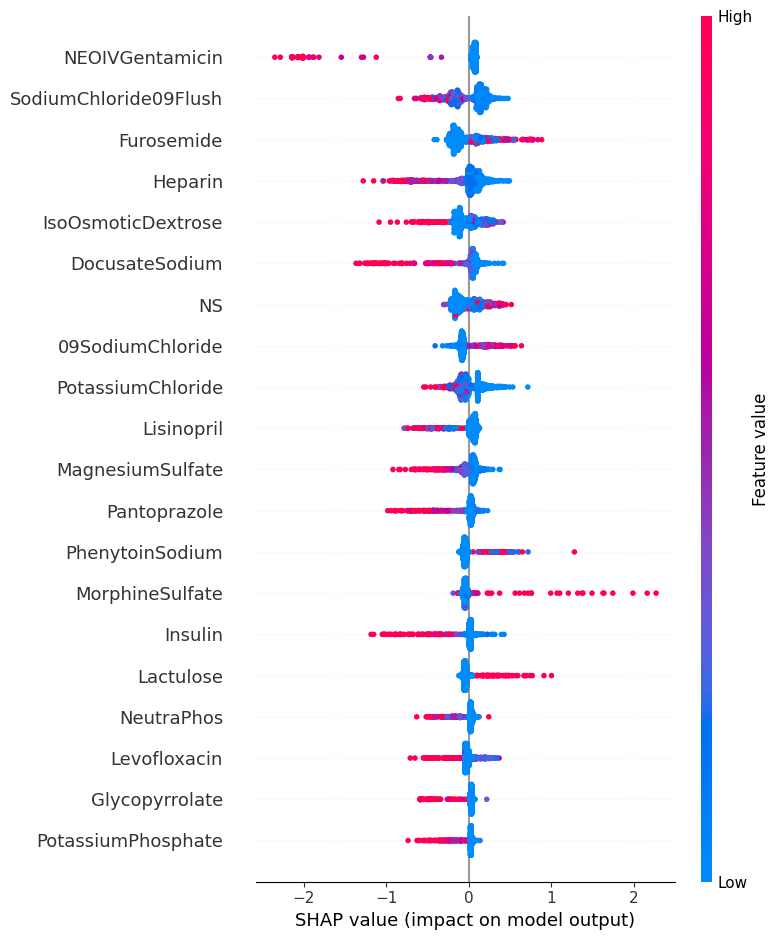


Feature importance based on SHAP TreeExplainer:
NEOIVGentamicin              0.198570
SodiumChloride09Flush        0.187800
Furosemide                   0.170820
Heparin                      0.158660
IsoOsmoticDextrose           0.142460
                               ...   
DocusateSodiumLiquid         0.014572
NystatinOralSuspension       0.014072
Oxycodone                    0.013865
NitroglycerinSL              0.013722
OxycoDONEImmediateRelease    0.013399
Length: 100, dtype: float32

--------------------------------------------------



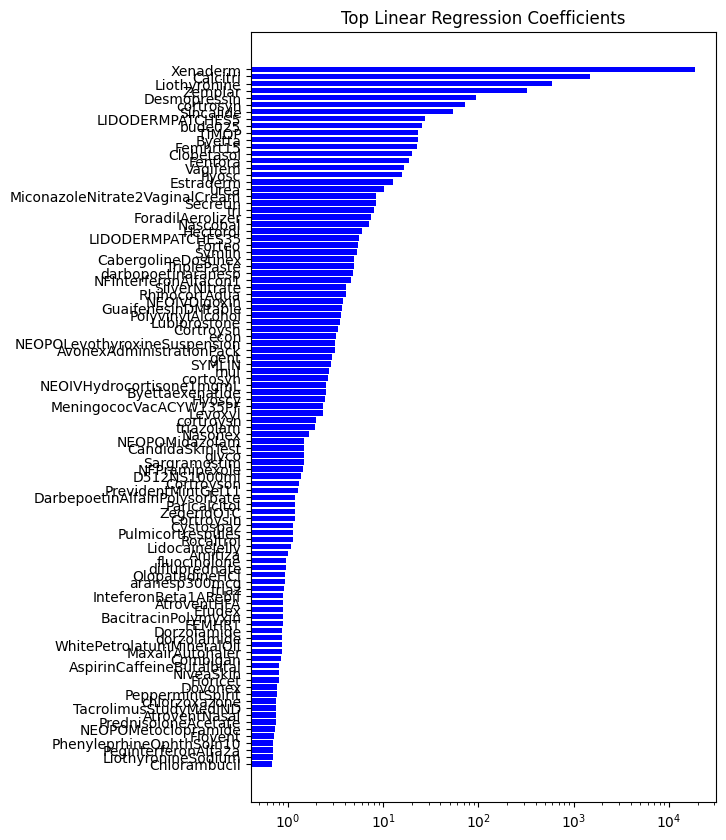

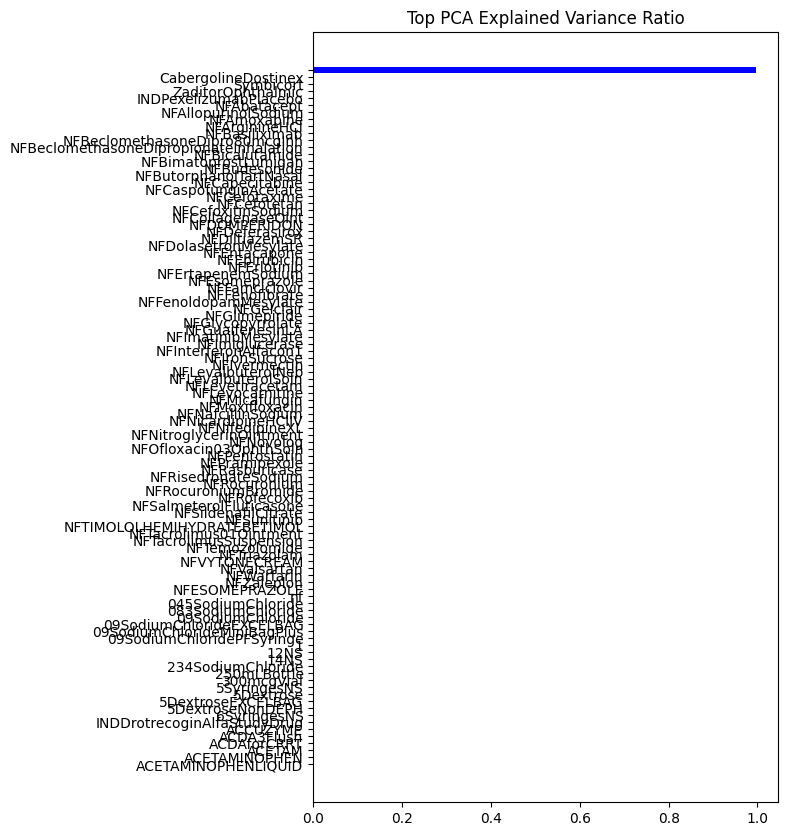

Number of selected features: 296
Selected features: ['', 'CabergolineDostinex', 'Symbicort', 'ZaditorOphthalmic', 'INDPexelizumabPlacebo', 'NFAbatacept', 'NFAllopurinolSodium', 'NFAmoxapine', 'NFArginineHCl', 'NFBasiliximab', 'NFBeclomethasoneDipro80mcgInh', 'NFBeclomethasoneDipropionateInhalation', 'NFBicalutamide', 'NFBimatoprostLumigan', 'NFBudesonide', 'NFButorphanolTartNasal', 'NFCapecitabine', 'NFCaspofunginAcetate', 'NFCefotaxime', 'NFCefotetan', 'NFCefoxitinSodium', 'NFCollagenaseOint', 'NFDOMPERIDON', 'NFDeferasirox', 'NFDiltiazemSR', 'NFDolasetronMesylate', 'NFEntacapone', 'NFEpirubicin', 'NFErlotinib', 'NFErtapenemSodium', 'NFEsomeprazole', 'NFFamciclovir', 'NFFenofibrate', 'NFFenoldopamMesylate', 'NFGelclair', 'NFGlimepiride', 'NFGlycopyrrolate', 'NFGuaifenesinLA', 'NFImatinibMesylate', 'NFImiglucerase', 'NFInterferonAlfacon1', 'NFIronSucrose', 'NFIvermectin', 'NFLevalbuterolNeb', 'NFLevalbuterolSoln', 'NFLevetiracetam', 'NFLevocarnitine', 'NFMicafungin', 'NFMoxifloxacin', 

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
Labelling data...: 100%|██████████| 445/445 [00:06<00:00, 69.01it/s]


445 features remaining after final filtration
47541 patients remaining after final filtration


Epoch 0: 100%|██████████| 2510/2510 [00:05<00:00, 453.03it/s]


Epoch [1/2], Loss: 0.0679


Epoch 1: 100%|██████████| 2510/2510 [00:05<00:00, 472.72it/s]


Epoch [2/2], Loss: 0.0627


Encoding...: 100%|██████████| 40158/40158 [00:03<00:00, 10150.05it/s]


Imputing...


[IterativeImputer] Early stopping criterion not reached.


MICE Imputation finished in 122.6126 minutes!


In [5]:
# Config options for mode
hours = 72
feature_threshold = 0.4
patient_threshold = 0.1

# Obtains features
train_features, test_features, train_labels, test_labels, feature_df, primary_scaler, labellers = obtain_features(max_hours = hours, feature_threshold = feature_threshold,
                                   patient_threshold = patient_threshold, icu_codes = True, prescriptions = True)


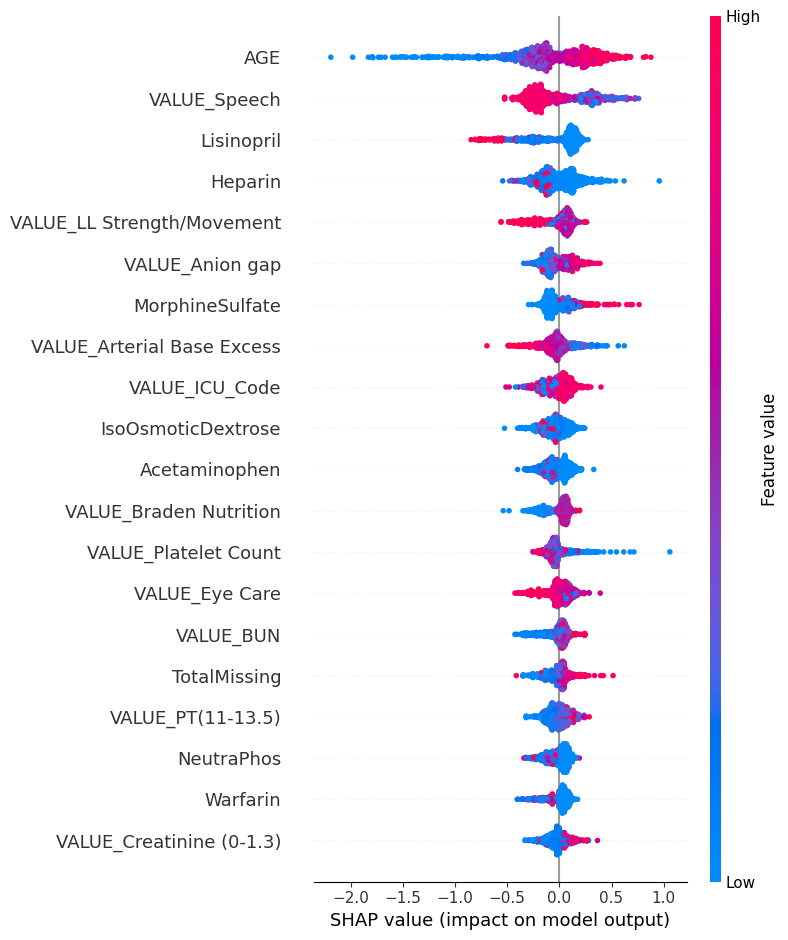


Feature importance based on SHAP TreeExplainer:
AGE                           0.324078
VALUE_Speech                  0.238741
Lisinopril                    0.190963
Heparin                       0.139718
VALUE_LL Strength/Movement    0.120985
VALUE_Anion gap               0.105115
MorphineSulfate               0.102509
VALUE_Arterial Base Excess    0.100794
VALUE_ICU_Code                0.092168
IsoOsmoticDextrose            0.089165
Acetaminophen                 0.088621
VALUE_Braden Nutrition        0.087544
VALUE_Platelet Count          0.080733
VALUE_Eye Care                0.079960
VALUE_BUN                     0.075860
TotalMissing                  0.075139
VALUE_PT(11-13.5)             0.074080
NeutraPhos                    0.073524
Warfarin                      0.068662
VALUE_Creatinine (0-1.3)      0.068661
Furosemide                    0.067017
VALUE_RL Strength/Movement    0.066794
VALUE_PTT(22-35)              0.066771
VALUE_Urine Appearance        0.065083
SodiumChloride0

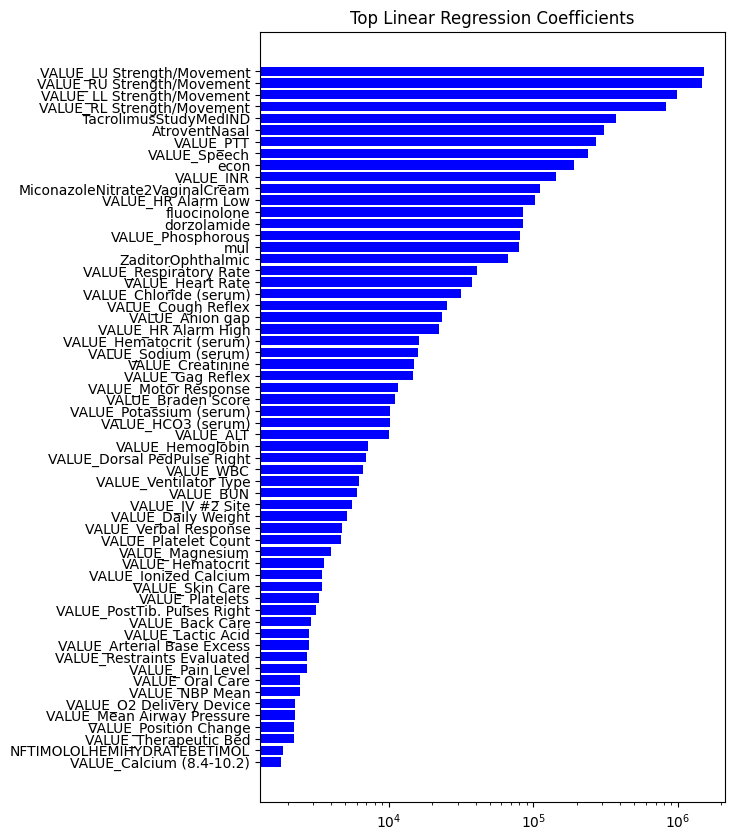

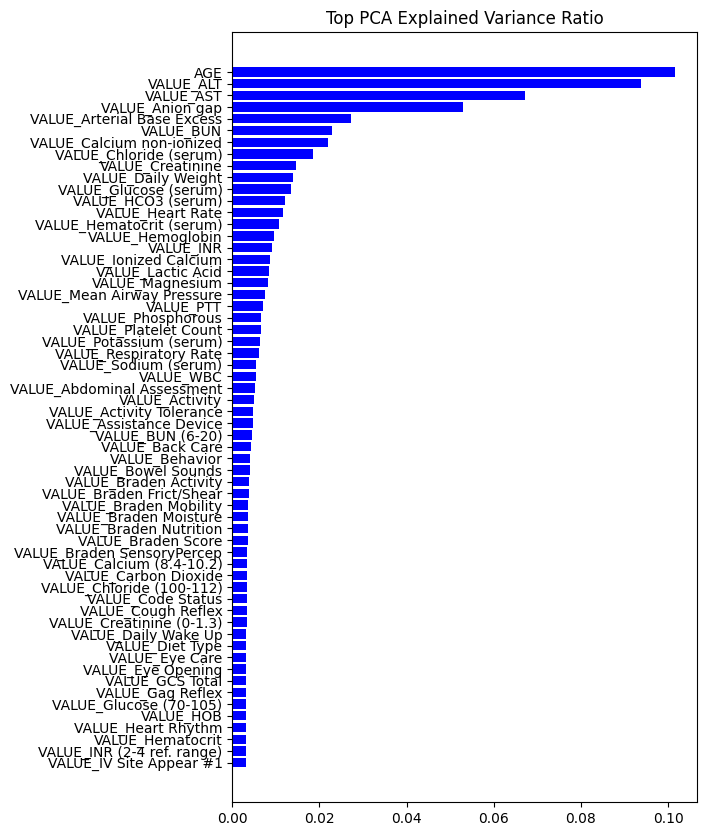

Number of selected features: 122
Selected features: ['AGE', 'VALUE_ALT', 'VALUE_AST', 'VALUE_Anion gap', 'VALUE_Arterial Base Excess', 'VALUE_BUN', 'VALUE_Calcium non-ionized', 'VALUE_Chloride (serum)', 'VALUE_Creatinine', 'VALUE_Daily Weight', 'VALUE_Glucose (serum)', 'VALUE_HCO3 (serum)', 'VALUE_Heart Rate', 'VALUE_Hematocrit (serum)', 'VALUE_Hemoglobin', 'VALUE_INR', 'VALUE_Ionized Calcium', 'VALUE_Lactic Acid', 'VALUE_Magnesium', 'VALUE_Mean Airway Pressure', 'VALUE_PTT', 'VALUE_Phosphorous', 'VALUE_Platelet Count', 'VALUE_Potassium (serum)', 'VALUE_Respiratory Rate', 'VALUE_Sodium (serum)', 'VALUE_WBC', 'VALUE_Abdominal Assessment', 'VALUE_Activity', 'VALUE_Activity Tolerance', 'VALUE_Assistance Device', 'VALUE_BUN (6-20)', 'VALUE_Back Care', 'VALUE_Behavior', 'VALUE_Bowel Sounds', 'VALUE_Braden Activity', 'VALUE_Braden Frict/Shear', 'VALUE_Braden Mobility', 'VALUE_Braden Moisture', 'VALUE_Braden Nutrition', 'VALUE_Braden Score', 'VALUE_Braden SensoryPercep', 'VALUE_Calcium (8.4-1

In [6]:
# Performs feature analysis
feature_names = feature_analysis(train_features, train_labels, top_features = 60)

Minority class count: 2778
Majority class count: 32601
Minority class count: 687
Majority class count: 8158
Starting analysis for Random Forest


K-Fold Validation: Random Forest: 100%|██████████| 5/5 [02:12<00:00, 26.58s/it]


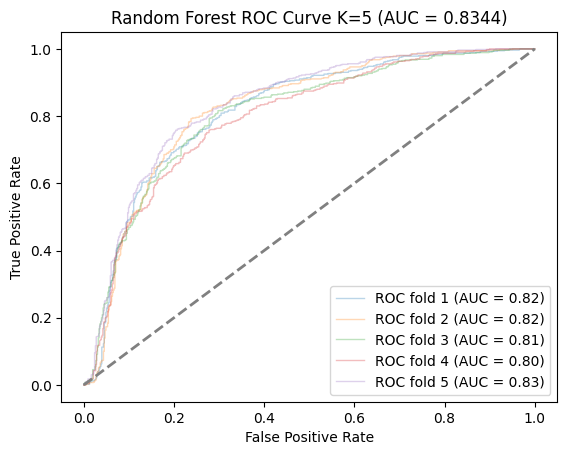

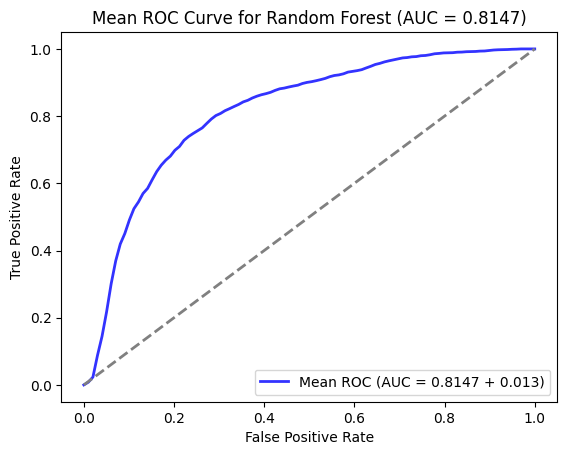

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Mean Validation AUC for Random Forest: 0.814 ± 0.013
Final Test AUC: 0.831
Final Test Sensitivity: 0.798
Final Test Specificity: 0.744
Model saved to saved_models/saved_results_Random Forest.joblib
Starting analysis for XGBoost


K-Fold Validation: XGBoost:   0%|          | 0/5 [00:00<?, ?it/s][23:51:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "name" } are not used.

K-Fold Validation: XGBoost:  20%|██        | 1/5 [00:05<00:23,  5.97s/it][23:52:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "name" } are not used.

K-Fold Validation: XGBoost:  40%|████      | 2/5 [00:09<00:12,  4.27s/it][23:52:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "name" } are not used.

K-Fold Validation: XGBoost:  60%|██████    | 3/5 [00:12<00:07,  3.74s/it][23:52:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "name" } are not used.

K-Fold Validation: XGBoost:  80%|████████  | 4/5 [00:27<00:08,  8.43s/it][23:52:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "name" } are not used.

K-Fold Validation: XGBoost: 100%|██████████| 5/5 [00:30<00:00,  6.15s/it]


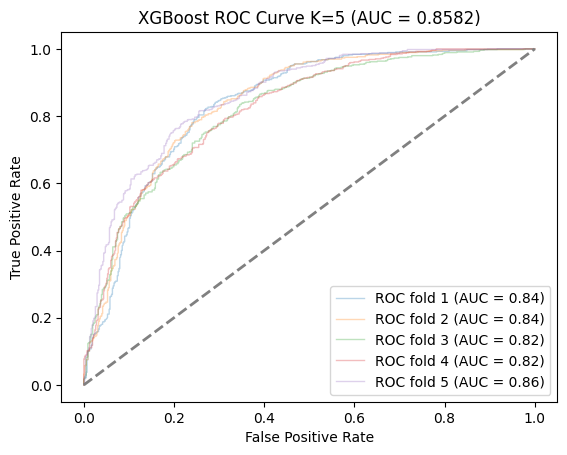

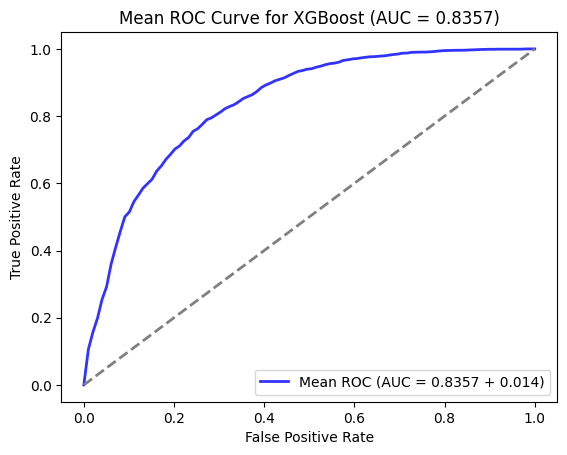

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Mean Validation AUC for XGBoost: 0.836 ± 0.014


[23:52:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "name" } are not used.



Final Test AUC: 0.864
Final Test Sensitivity: 0.793
Final Test Specificity: 0.751
Model saved to saved_models/saved_results_XGBoost.joblib


In [7]:
# Tests model
RF, XGB, scaler = test_models(train_features, train_labels, 
                              test_features, test_labels,
                              feature_names = feature_names, rescale = True)

# Inference

In [8]:
def inference_pipeline(feature_df, 
                       feature_drop,
                       true_labels, 
                       model,
                       subject_id,
                       feature_columns, 
                       feature_vector = None):
    """
    A pipeline to perform inference for a given patient by imputing missing features
    based on similar patients in the training dataset.

    :param feature_df: Path to the feature dataframe or  file.
    :param model: A scikit-learn model or the path to a saved model file.
    :param subject_id: The subject ID for which to perform the inference.
    :param feature_columns: List of features expected by the model.
    :return: The prediction for the given subject_id.
    """

    try:
        feature_df.columns
    except:
        feature_df = pd.read_csv(feature_df)

    # Obtains a random subject from df if no feature vector
    if subject_id:
        # Populates fake subject IDs for security
        if 'SUBJECT_ID' not in feature_df.columns:
            subject_ids = [i for i in range(len(feature_df))]
            feature_df['SUBJECT_ID'] = subject_ids
    
        # Sets subjectID if unknown 
        if subject_id == 'random':
            subject_id = random.sample(list(set(feature_df['SUBJECT_ID'])), 1)[0]
            
        subject_features = feature_df[feature_df['SUBJECT_ID'] == subject_id]
        label_index = int(subject_features.index.item())
    
        # Reduce to the relevant features, handling missing data
        drop_features = int(feature_drop * len(feature_columns))
        selected_feature_columns = random.sample(feature_columns, len(feature_columns) - drop_features)
        feature_vector = subject_features[selected_feature_columns].dropna(axis=1)

    missing_features = set(feature_columns) - set(feature_vector.columns)
                               
    # Use training data to find similar patients and sample missing features
    knn = NearestNeighbors(n_neighbors=5).fit(feature_df[selected_feature_columns])
    _, indices = knn.kneighbors(feature_vector)
    similar_patients_indices = indices.flatten()
    
    for feature in missing_features:
        similar_feature_values = feature_df.iloc[similar_patients_indices][feature].dropna()
        if not similar_feature_values.empty:
            try:
                distribution = gaussian_kde(similar_feature_values)
                sampled_value = distribution.resample(1)[0]
            except:
                sampled_value = np.mean(similar_feature_values.iloc[0])
            feature_vector[feature] = sampled_value  # Assuming recent_features has one row for the subject
            
    # Prepare the feature vector for prediction
    feature_vector = np.array([feature_vector[feature].iloc[0] for feature in feature_columns]).reshape(1, -1)
    feature_vector = scaler.fit_transform(feature_vector)
    
    # Make prediction
    prediction_probability = model.predict_proba(feature_vector)
    prediction = np.argmax(prediction_probability)

    try:
        if prediction == true_labels[label_index]:
            return prediction, 1
        else:
            return prediction, 0
    except:
        return prediction_probability[1]

In [9]:
feature_drops = [0, 0.25, 0.5, 0.8, 0.9, 0.95]
sample_numbers = [100, 250, 500, 1000, 2000, 3000]
feature_vec = {}
for drop in feature_drops:
    feature_vec[drop] = []
    for sample_num in tqdm.tqdm(sample_numbers, total = len(sample_numbers), desc = f'Drop {drop}'):
        correct = 0
        for i in range(sample_num):
            prediction, value = inference_pipeline(feature_df = test_features,
                                        true_labels = test_labels,
                                        model = XGB, 
                                        subject_id = 'random', 
                                        feature_columns = feature_names,  
                                        feature_drop = drop)
            correct += value
        feature_vec[drop].append(correct/sample_num)
plt.figure()
for drop, value in feature_vec.items():
    plt.plot(sample_numbers, value, label = f'{drop}')
plt.xlabel('Sample number')
plt.legend()
plt.ylabel('Probability correct')
plt.show()
    

Drop 0:   0%|          | 0/6 [00:02<?, ?it/s]


IndexError: index 1 is out of bounds for axis 0 with size 1